# Bayesian Dynamic TWFE

In [1]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import scipy.stats as stats
from patsy import dmatrix

import pymc as pm
import pymc_experimental.statespace.models.structural as st
import pytensor.tensor as pt
import arviz as az
az.style.use('arviz-darkgrid')
import numpyro
import jax


In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df = df.dropna(subset=['population'])
df.loc[df['treatment_group'] == 0, 'time_since_treatment'] = np.nan # コントロール群の処置後経過年数は欠損値
df['time_since_treatment'] = np.nan_to_num(df['time_since_treatment'], nan=1000)


In [3]:
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_id, mn_island_ids = df.island_ids.factorize()

df.bridge_year = df.bridge_year.astype(str)
df.bridge_year = df.bridge_year.map(str.strip)
bridge_years, mn_bridge_years = df.bridge_year.factorize()

df['time_since_treatment'] = df['time_since_treatment'].astype(str)
df['time_since_treatment'] = df['time_since_treatment'].map(str.strip)
time_since_treatment, mn_time_since_treatments = df['time_since_treatment'].factorize()


In [4]:
# サンプリングのインポート
trace_homo = az.from_netcdf('./mcmc_sample/dynamic/homo_20240111.nc')
# trace_smoothing = az.from_netcdf('./mcmc_sample/dynamic/smoothing_20250111.nc')

## Dynamic TWFE

$$
\begin{aligned}
Y_{it} = \alpha_i + \lambda_t + \beta_l \cdot T_{i}  + \epsilon_{it} \\
\end{aligned}
$$

- $\beta_l$: 介入前後の経過時間

## 階層ベイズモデル 不均一分散

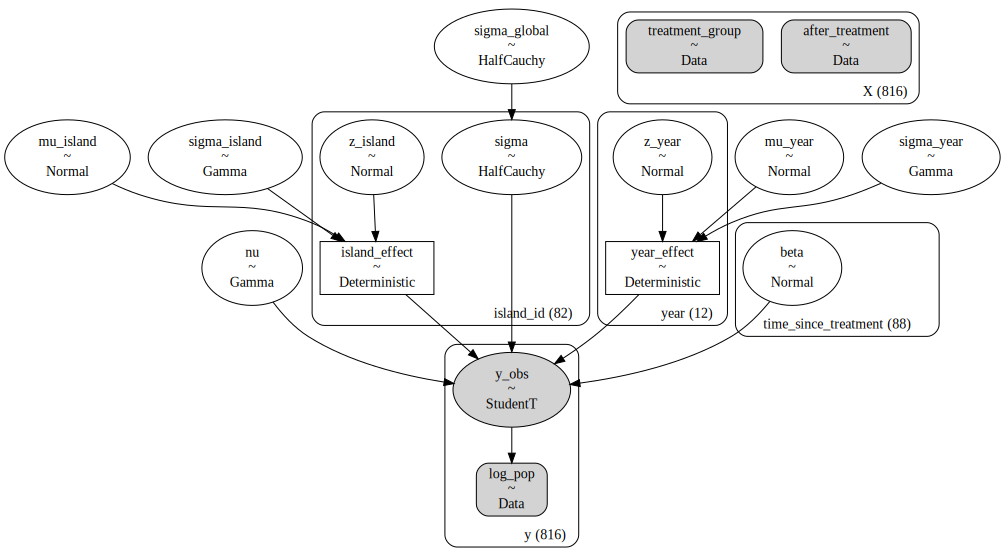

In [277]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
# 介入経過年数をダミー化
time_since_treatment_dummies = dmatrix('C(time_since_treatment) - 1', df, return_type='dataframe')
time_since_treatment_dummies.drop(columns=['C(time_since_treatment)[-46.0]', 'C(time_since_treatment)[1000.0]'], axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'time_since_treatment': time_since_treatment_dummies.columns,
}

with pm.Model(coords=COORDS) as model_hetero:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect

    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    sigma_global = pm.HalfCauchy('sigma_global', 1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_global, dims='island_id')

    # fixed effect
    # alpha = pm.Normal('alpha', qmu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='time_since_treatment')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(time_since_treatment_dummies, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_id], observed=log_pop, dims='y')

pm.model_to_graphviz(model_hetero)

In [278]:
with model_hetero:
    trace_hetero = pm.sample(
        draws=500,
        tune=500,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
        target_accept=.99
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [279]:
az.summary(trace_hetero, var_names=['sigma_global', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year', 'nu'], hdi_prob=0.95)

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
sigma_global   0.165   0.020     0.129      0.207      0.001    0.001   
mu_island      6.418   0.142     6.099      6.674      0.044    0.032   
sigma_island   1.981   0.156     1.609      2.356      0.063    0.047   
mu_year       -0.490   0.172    -0.889     -0.165      0.052    0.038   
sigma_year     0.627   0.125     0.387      0.861      0.013    0.009   
nu            27.495  14.187     8.756     57.363      2.064    1.469   

              ess_bulk  ess_tail  r_hat  
sigma_global     299.0     561.0   1.11  
mu_island         11.0      93.0   1.36  
sigma_island       6.0      15.0   1.76  
mu_year           11.0      28.0   1.30  
sigma_year        81.0     170.0   1.50  
nu                46.0     397.0   1.15

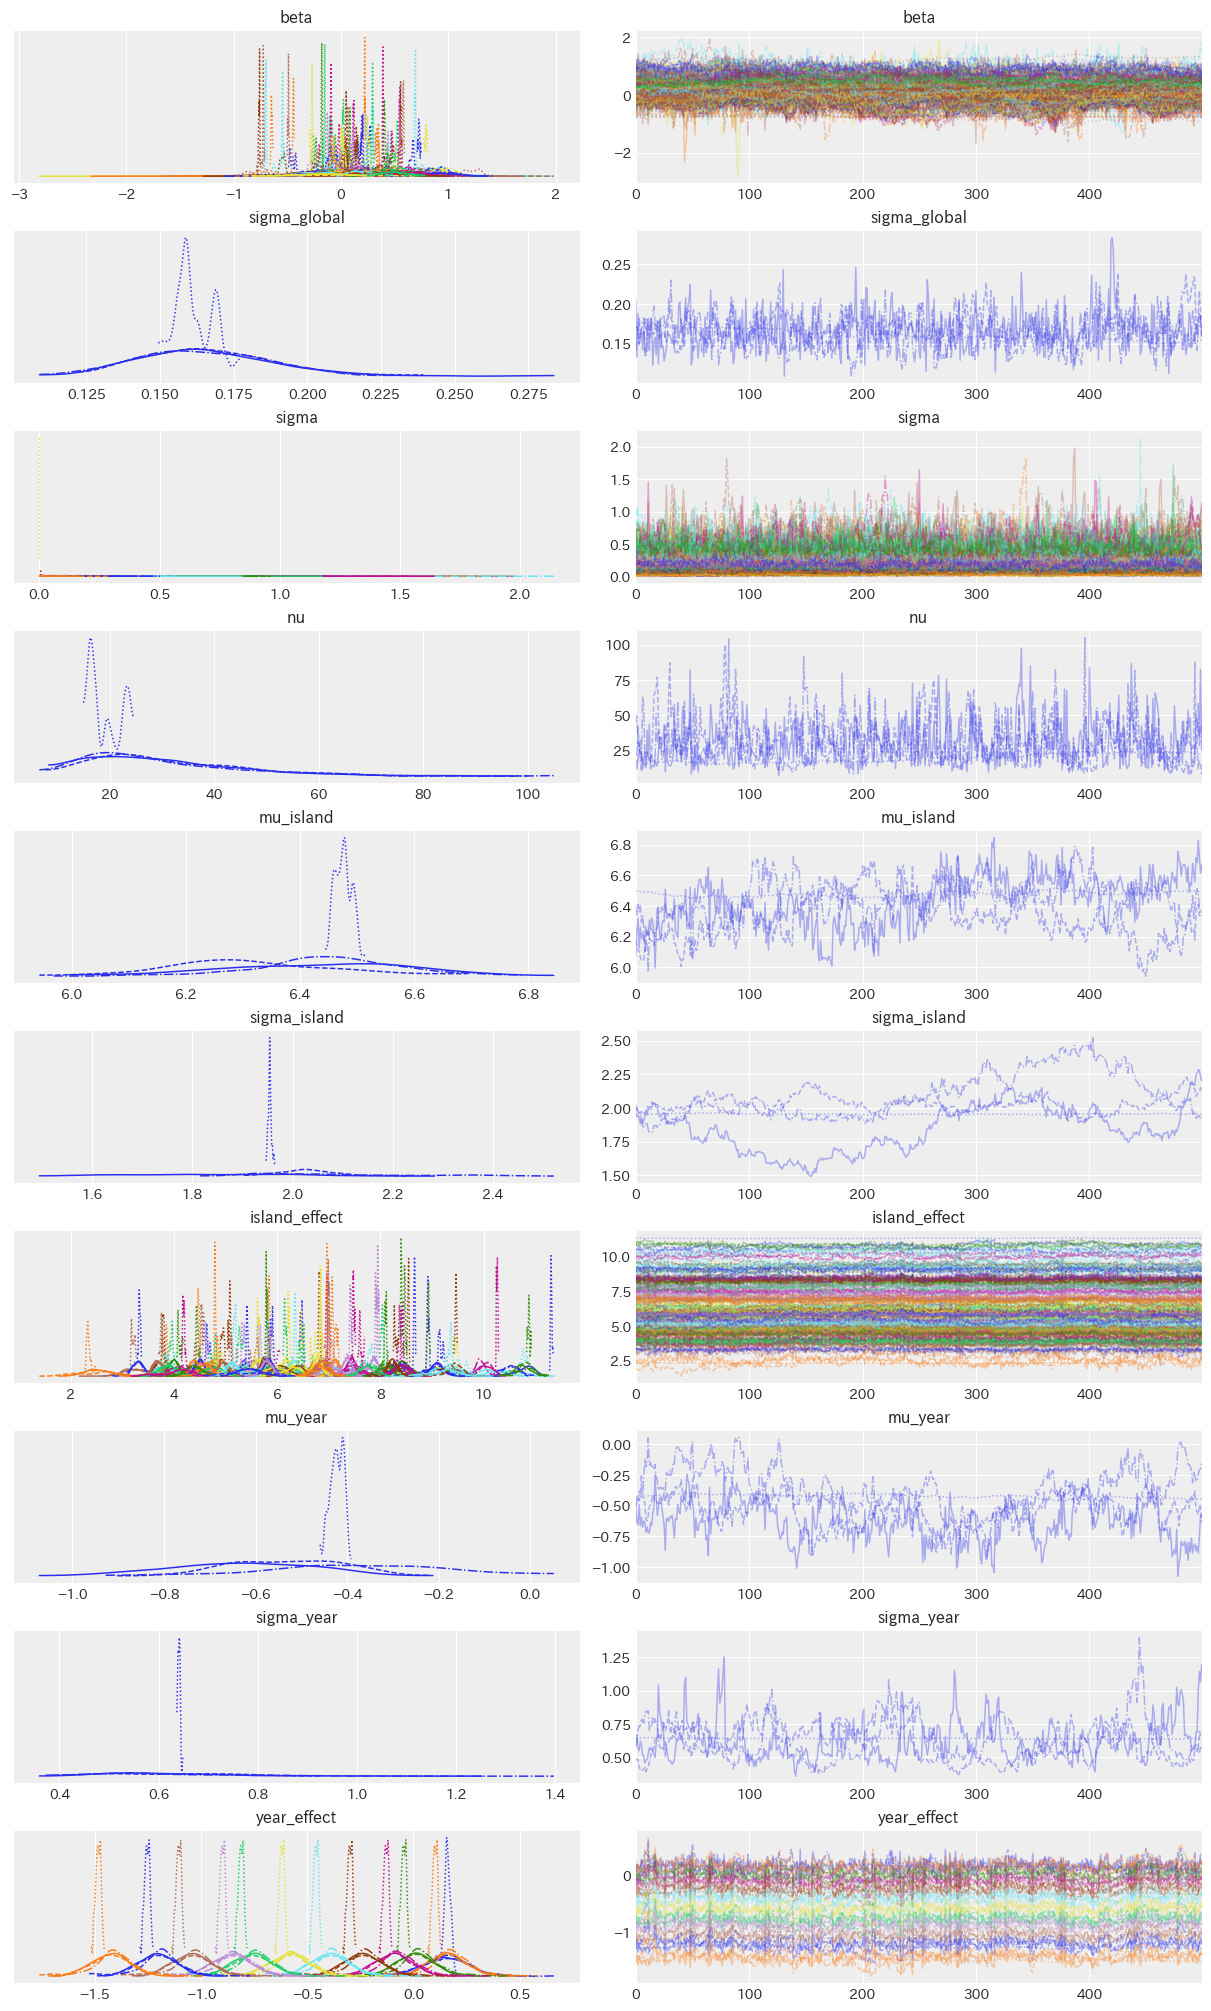

In [280]:
az.plot_trace(
    trace_hetero,
    var_names=[
        'beta', 'sigma_global', 'sigma', 'nu',
        'mu_island', 'sigma_island', 'island_effect',
        'mu_year', 'sigma_year', 'year_effect',
    ]
);

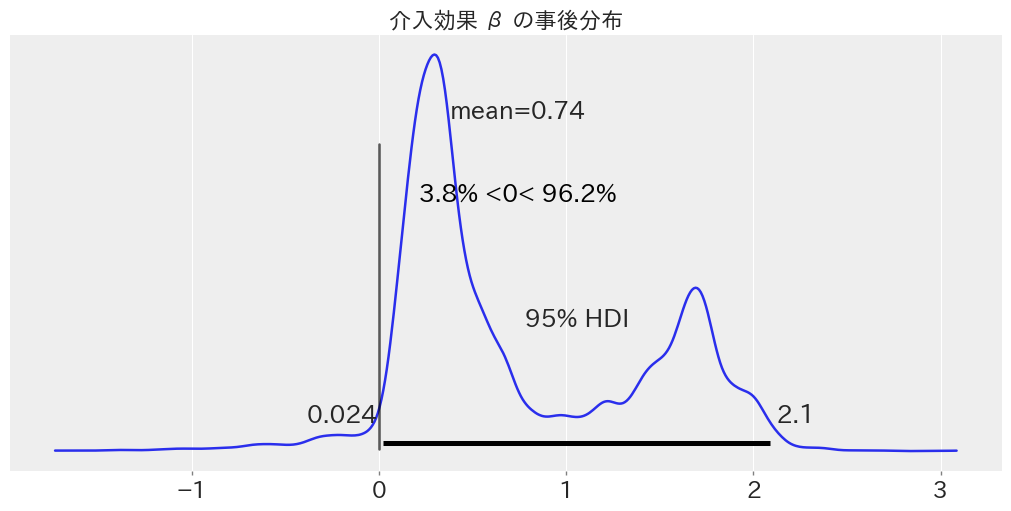

In [59]:
az.plot_posterior(trace_hetero, var_names=['mu_beta'], hdi_prob=0.95, ref_val=0, ref_val_color='k', figsize=(10 ,5));
plt.title('介入効果 β の事後分布');

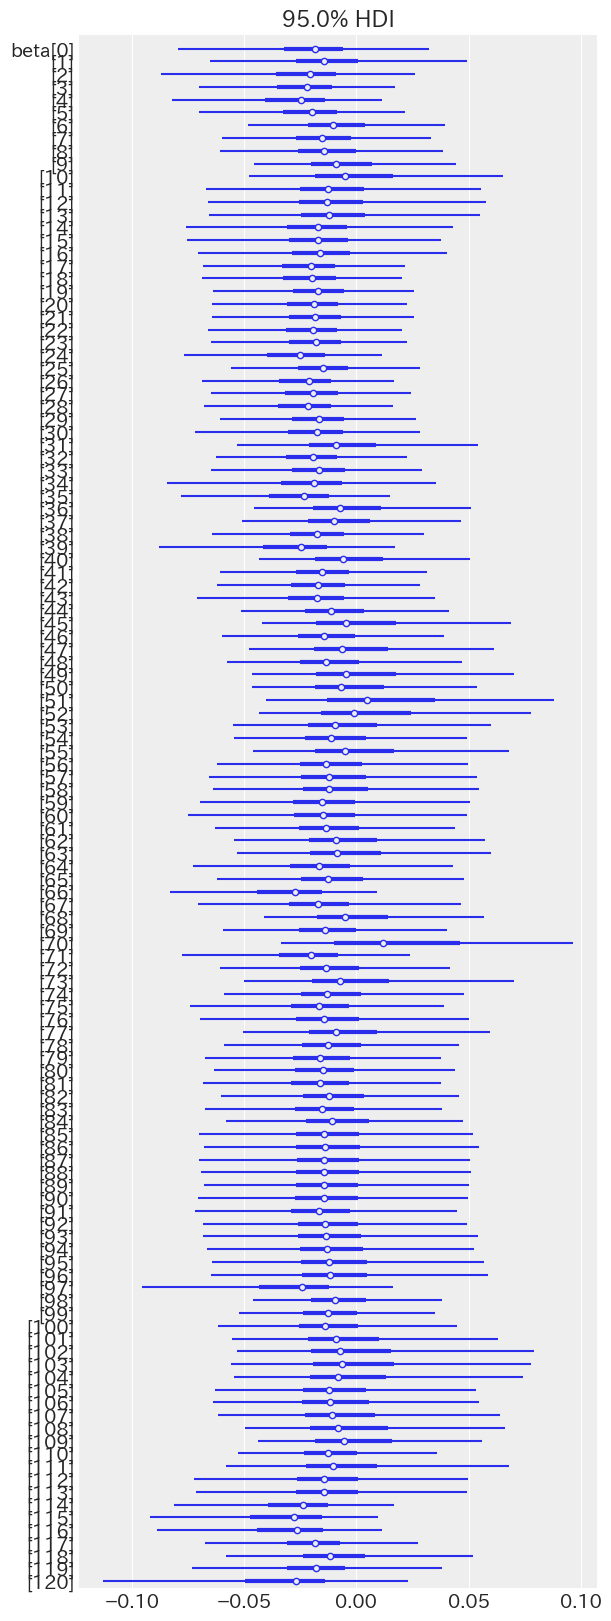

In [16]:
az.plot_forest(trace_dynamic_twfe, var_names=['beta'], combined=True, hdi_prob=0.95);

In [9]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   494.26    42.64
p_waic      103.58        -

There has been a warning during the calculation. Please check the results.

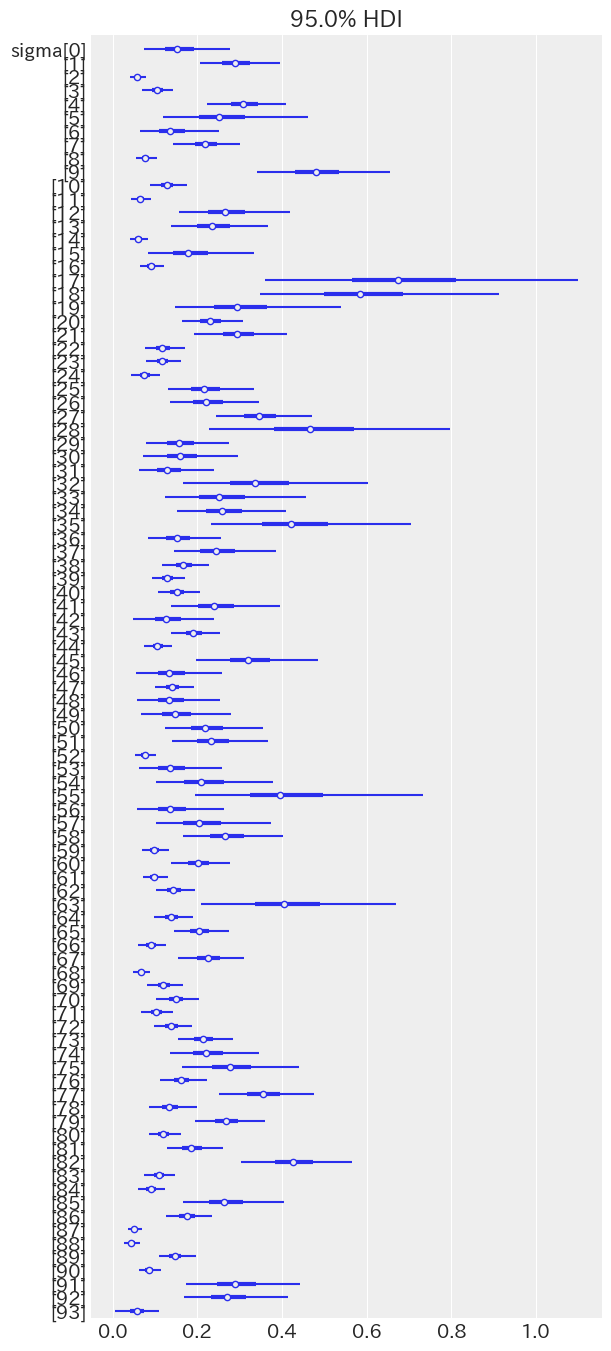

In [75]:
az.plot_forest(trace_dynamic_twfe, var_names=['sigma'], combined=True, hdi_prob=0.95);

## 階層ベイズモデル 均一分散

$$
\begin{aligned}
\log{Y_{it}} = \beta_i \cdot  W_{it} + \epsilon_{it} \\
\epsilon_{it} \sim N(0, \sigma^2)
\end{aligned}
$$

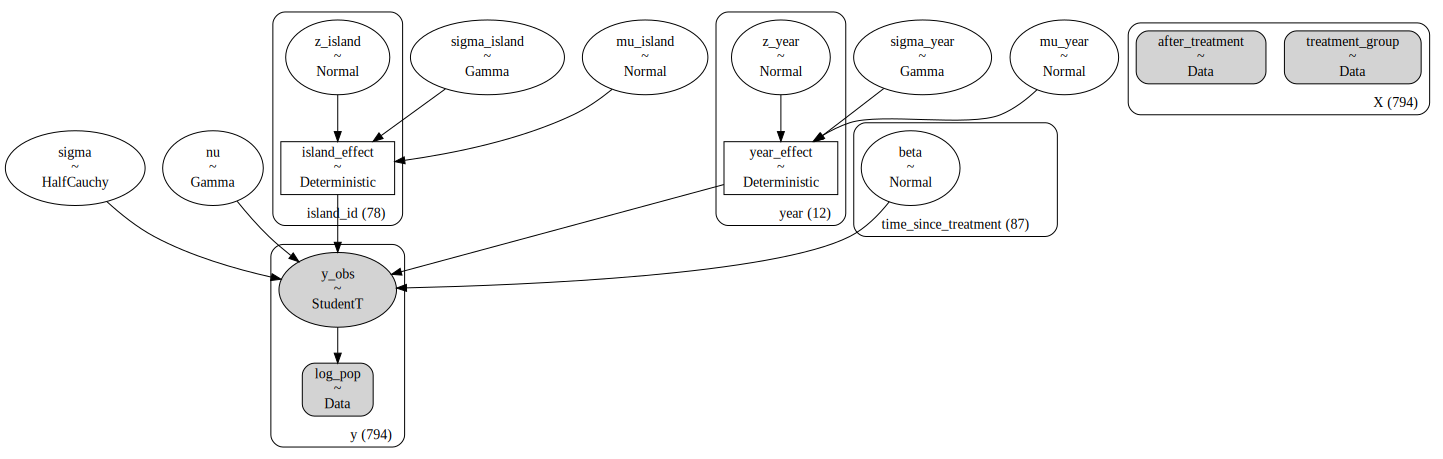

In [4]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
# 介入経過年数をダミー化
time_since_treatment_dummies = dmatrix('C(time_since_treatment) - 1', df, return_type='dataframe')
time_since_treatment_dummies.drop(columns=['C(time_since_treatment)[1000.0]'], axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'time_since_treatment': time_since_treatment_dummies.columns,
}

with pm.Model(coords=COORDS) as model_homo:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    year = pm.Data('year', df['year'], dims='X')
    treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect

    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    # mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    # sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    # z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    # year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')
    year_effect = pm.Normal('year_effect', mu=-1, sigma=1, dims='year')

    sigma = pm.HalfCauchy('sigma', beta=1)

    # fixed effect
    # alpha = pm.Normal('alpha', qmu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, dims='time_since_treatment')
    gamma = pm.Normal('gamma', mu=0, sigma=1, dims='island_id')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(time_since_treatment_dummies, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect) + gamma[island_id] * year

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop, dims='y')

pm.model_to_graphviz(model_homo)

In [5]:
with model_homo:
    trace_homo = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [6]:
az.to_netcdf(trace_homo, './mcmc_sample/dynamic/homo_20240111.nc')

'./mcmc_sample/dynamic/homo_20240111.nc'

In [7]:
az.summary(trace_homo, var_names=['sigma', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year', 'nu'], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
sigma         0.119  0.010     0.101      0.138      0.000    0.000    2554.0   
mu_island     6.489  0.258     5.993      7.006      0.006    0.004    1656.0   
sigma_island  1.966  0.163     1.646      2.284      0.004    0.003    1384.0   
mu_year      -0.758  0.225    -1.196     -0.304      0.004    0.003    4077.0   
sigma_year    0.643  0.161     0.380      0.951      0.003    0.002    3405.0   
nu            1.881  0.231     1.452      2.329      0.004    0.003    3435.0   

              ess_tail  r_hat  
sigma           4008.0    1.0  
mu_island       2839.0    1.0  
sigma_island    2409.0    1.0  
mu_year         4495.0    1.0  
sigma_year      4649.0    1.0  
nu              4639.0    1.0

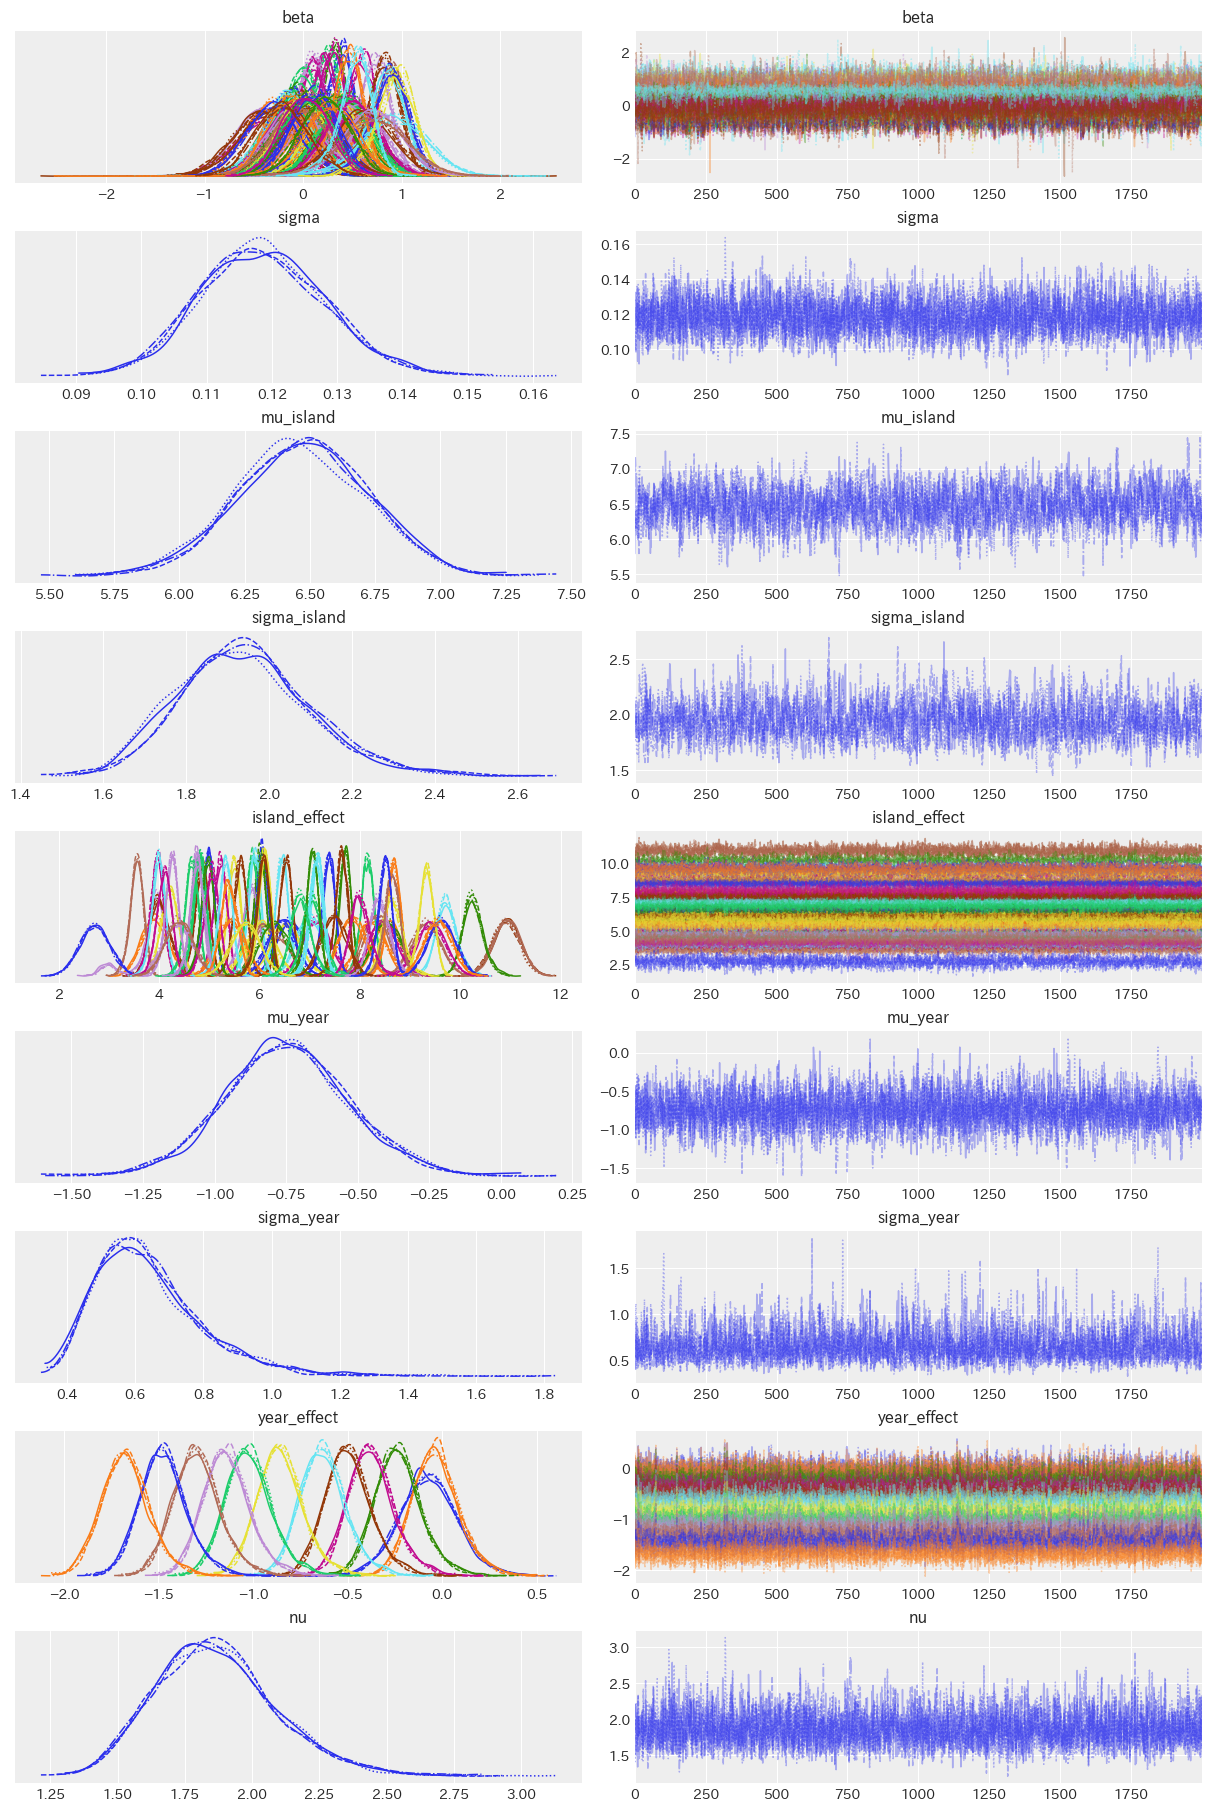

In [10]:
az.plot_trace(
    trace_homo,
    var_names=[
        'beta',
        'sigma',
        'mu_island', 'sigma_island', 'island_effect',
        'mu_year', 'sigma_year', 'year_effect',
        'nu'
    ]
);

In [9]:
with model_homo:
    pm.compute_log_likelihood(trace_homo)

az.waic(trace_homo)

Output()

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 782 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -58.91    32.75
p_waic      252.72        -

There has been a warning during the calculation. Please check the results.

## プロット

In [5]:
def get_beta_df(trace):
    # ランダム効果のサマリーを取得
    beta_df = az.summary(trace, var_names=['beta'], hdi_prob=0.95, kind='stats')

    # 経過年数
    # time_since_treatment_df = pd.DataFrame(unique_time_since_treatment, columns=['time_since_treatment_str'])
    # time_since_treatment_df['time_since_treatment'] = time_since_treatment_df['time_since_treatment_str'].apply(extract_number)

    # ランダム効果の値を経過年数と結合
    # ランダム効果の順番は経過年数の昇順ではなく，データに登場した順番になっている．
    # beta_df.reset_index(drop=True, inplace=True)
    # beta_df = pd.concat([beta_df, time_since_treatment_df], axis=1)
    # pattern = r'beta\[(\-?\d+.\d+)\]' # beta[-45.0]
    pattern = r"beta\[C\(time_since_treatment\)\[(-?\d+\.\d+)\]\]"
    extracted = beta_df.index.str.extract(pattern)
    extracted.index = beta_df.index
    beta_df['time_since_treatment'] = extracted[0].astype(float)
    beta_df = beta_df.query('time_since_treatment < 1000').sort_values('time_since_treatment')

    # 新しい列に数値を格納

    return beta_df

class BetaPlotter:
    def __init__(self, beta_df):
        self.beta_df = beta_df

    def plot_effects_over_time(self, title):
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.lineplot(
            x='time_since_treatment',
            y='mean',
            data=self.beta_df,
            # marker='o',
            color='black',
            label='期待値',
            ax=ax
        )
        ax.fill_between(
            x=self.beta_df['time_since_treatment'],
            y1=self.beta_df['hdi_97.5%'],
            y2=self.beta_df['hdi_2.5%'],
            color='gray',
            alpha=0.5,
            label='95%信用区間'
        )
        ax.axvline(x=0, color='black', linestyle=':')
        ax.axhline(y=0, color='black', linestyle=':')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('')
        ax.set_title(title)
        ax.legend()
        path = '../../docs/figures/dynamic_twfe/ATT.png'
        plt.savefig(path, bbox_inches='tight')

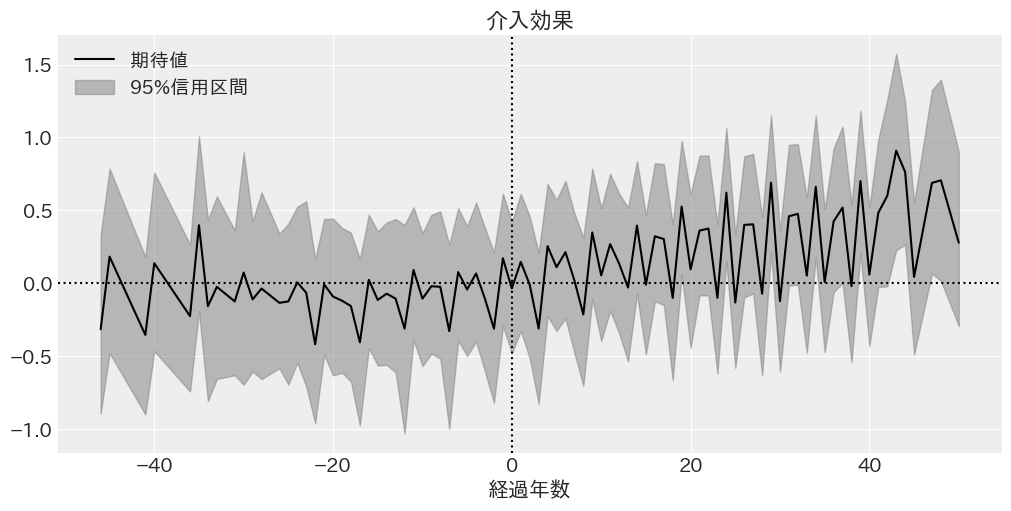

In [8]:
beta_df = get_beta_df(trace_homo)
plotter = BetaPlotter(beta_df)
plotter.plot_effects_over_time('介入効果')

In [9]:
beta_df.rename(columns={'hdi_2.5%': 'hdi_lwr', 'hdi_97.5%': 'hdi_upr'}, inplace=True)

In [10]:
beta_samples = pd.read_csv('../../data/processed/dynamic_twfe/beta_samples.csv')

In [35]:
beta_ell_df_pre.iloc[:, 0:5]

C(time_since_treatment)[-46.0]  C(time_since_treatment)[-45.0]  \
0                           0.090788                       -0.102297   
1                           0.152397                       -0.173183   
2                           0.508598                        0.212228   
3                           0.119660                       -0.173882   
4                           0.075493                       -0.138878   
...                              ...                             ...   
7995                        0.301317                        0.045446   
7996                       -0.122312                        0.499837   
7997                        0.191555                       -0.231637   
7998                        0.258478                       -0.010429   
7999                        0.285480                        0.094960   

      C(time_since_treatment)[-41.0]  C(time_since_treatment)[-40.0]  \
0                           0.017909                       -0.247537   
1                           0.163358                       -0.986249   
2                           0.403724                       -0.918280   
3                           0.146338                       -0.644422   
4                          -0.014410                        0.003614   
...                              ...                             ...   
7995                        0.160477                       -0.426400   
7996                       -0.178443                       -1.032150   
7997                        0.084034                       -0.119886   
7998                        0.316076                       -0.806726   
7999                        0.188821                       -0.427066   

      C(time_since_treatment)[-36.0]  
0                           0.123609  
1                           0.065527  
2                          -0.414294  
3                          -0.540557  
4                          -0.044161  
...                              ...  
7995                       -0.271534  
7996                        0.002483  
7997                        0.183195  
7998                       -0.278962  
7999                       -0.155349  

[8000 rows x 5 columns]

In [39]:
# 介入前の推定量
negative_columns = [col for col in beta_samples.columns if re.search(r'-\d+\.\d+', col)]
beta_ell_df_pre = beta_samples[negative_columns]

total_elements_pre = beta_ell_df_pre.size
positive_elements_pre = (beta_ell_df_pre > 0).sum().sum()
positive_ratio_pre = positive_elements_pre / total_elements_pre
eap = np.exp(beta_ell_df_pre.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入前で正の確率: {positive_ratio_pre:.3%}')

# -10 ~ -1
beta_ell_df_pre_10 = beta_ell_df_pre.iloc[:, 28:-1]
total_elements_pre_10 = beta_ell_df_pre_10.size
positive_elements_pre_10 = (beta_ell_df_pre_10 > 0).sum().sum()
positive_ratio_pre_10 = positive_elements_pre_10 / total_elements_pre_10
eap = np.exp(beta_ell_df_pre_10.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入前10年間で正の確率: {positive_ratio_pre_10:.3%}')

# -20 ~ -11
beta_ell_df_pre_20 = beta_ell_df_pre.iloc[:, 18:28]
total_elements_pre_20 = beta_ell_df_pre_20.size
positive_elements_pre_20 = (beta_ell_df_pre_20 > 0).sum().sum()
positive_ratio_pre_20 = positive_elements_pre_20 / total_elements_pre_20
eap = np.exp(beta_ell_df_pre_20.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入前20年間で正の確率: {positive_ratio_pre_20:.3%}')

# -30 ~ -21
beta_ell_df_pre_30 = beta_ell_df_pre.iloc[:, 9:18]
total_elements_pre_30 = beta_ell_df_pre_30.size
positive_elements_pre_30 = (beta_ell_df_pre_30 > 0).sum().sum()
positive_ratio_pre_30 = positive_elements_pre_30 / total_elements_pre_30
eap = np.exp(beta_ell_df_pre_30.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入前30年間で正の確率: {positive_ratio_pre_30:.3%}')

# -46 ~ -31
beta_ell_df_pre_40 = beta_ell_df_pre.iloc[:, 0:9]
total_elements_pre_40 = beta_ell_df_pre_40.size
positive_elements_pre_40 = (beta_ell_df_pre_40 > 0).sum().sum()
positive_ratio_pre_40 = positive_elements_pre_40 / total_elements_pre_40
eap = np.exp(beta_ell_df_pre_40.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入前40年間で正の確率: {positive_ratio_pre_40:.3%}')


EAP: -8.095%
介入前で正の確率: 39.278%
EAP: -6.519%
介入前10年間で正の確率: 43.492%
EAP: -4.438%
介入前20年間で正の確率: 41.055%
EAP: -13.388%
介入前30年間で正の確率: 31.710%
EAP: -8.829%
介入前40年間で正の確率: 39.828%


In [24]:
beta_ell_df_post.iloc[:, 11:21]

C(time_since_treatment)[11.0]  C(time_since_treatment)[12.0]  \
0                          0.566732                       0.201749   
1                          0.430607                       0.112523   
2                          0.756463                      -0.021230   
3                          0.475405                      -0.515170   
4                          0.530244                       0.143703   
...                             ...                            ...   
7995                       0.639819                      -0.012572   
7996                       0.183337                      -0.078595   
7997                       0.585432                       0.054374   
7998                       0.529728                      -0.126917   
7999                       0.553284                       0.043943   

      C(time_since_treatment)[13.0]  C(time_since_treatment)[14.0]  \
0                          0.299361                       0.249474   
1                          0.152456                       0.198983   
2                          0.761883                      -0.074888   
3                          0.130408                       0.633906   
4                         -0.256091                       0.412914   
...                             ...                            ...   
7995                       0.089822                       0.810895   
7996                       0.944309                       0.065282   
7997                       0.056125                       0.469785   
7998                       0.044847                       0.343180   
7999                       0.496756                       0.815376   

      C(time_since_treatment)[15.0]  C(time_since_treatment)[16.0]  \
0                          0.620388                      -0.050591   
1                          0.475808                      -0.399010   
2                          0.328353                      -0.268347   
3                         -0.143591                       0.021850   
4                          0.509447                       0.277897   
...                             ...                            ...   
7995                       0.486563                      -0.227535   
7996                       0.446993                      -0.899066   
7997                       0.493923                      -0.027359   
7998                       0.325810                      -0.545271   
7999                       0.324269                      -0.226500   

      C(time_since_treatment)[17.0]  C(time_since_treatment)[18.0]  \
0                          0.667001                      -0.123930   
1                          0.594467                      -0.271435   
2                          0.906796                       0.183081   
3                          0.575050                      -0.060502   
4                          0.469928                      -0.269556   
...                             ...                            ...   
7995                       0.698725                      -0.009000   
7996                       0.216036                       0.370343   
7997                       0.622588                      -0.129956   
7998                       0.704434                      -0.105034   
7999                       0.562046                       0.059160   

      C(time_since_treatment)[19.0]  C(time_since_treatment)[20.0]  
0                          0.387180                       0.619786  
1                          0.315501                       0.506492  
2                          0.086652                       0.371751  
3                          0.766859                      -0.085907  
4                          0.403324                       0.587897  
...                             ...                            ...  
7995                       0.841803                       0.405241  
7996                       0.123477                       0.452162  
7997                 

In [32]:
# 介入前の推定量
negative_columns = [col for col in beta_samples.columns if re.search(r'-\d+\.\d+', col)]
# 介入後の推定量
beta_ell_df_post = beta_samples.drop(columns=negative_columns)


total_elements_post = beta_ell_df_post.size
positive_elements_post = (beta_ell_df_post > 0).sum().sum()
positive_ratio_post = positive_elements_post / total_elements_post
eap = np.exp(beta_ell_df_post.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入後全期間で正の確率: {positive_ratio_post:.3%}')

beta_ell_df_post_10 = beta_ell_df_post.iloc[:, :11]
total_elements_post_10 = beta_ell_df_post_10.size
positive_elements_post_10 = (beta_ell_df_post_10 > 0).sum().sum()
positive_ratio_post_10 = positive_elements_post_10 / total_elements_post_10
eap = np.exp(beta_ell_df_post_10.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入後0~10年間で正の確率: {positive_ratio_post_10:.3%}')

beta_ell_df_post_20 = beta_ell_df_post.iloc[:, 11:21]
total_elements_post_20 = beta_ell_df_post_20.size
positive_elements_post_20 = (beta_ell_df_post_20 > 0).sum().sum()
positive_ratio_post_20 = positive_elements_post_20 / total_elements_post_20
eap = np.exp(beta_ell_df_post_20.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入後11~20年間で正の確率: {positive_ratio_post_20:.3%}')

beta_ell_df_post_30 = beta_ell_df_post.iloc[:, 21:31]
total_elements_post_30 = beta_ell_df_post_30.size
positive_elements_post_30 = (beta_ell_df_post_30 > 0).sum().sum()
positive_ratio_post_30 = positive_elements_post_30 / total_elements_post_30
eap = np.exp(beta_ell_df_post_30.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入後21~30年間で正の確率: {positive_ratio_post_30:.3%}')

beta_ell_df_post_40 = beta_ell_df_post.iloc[:, 31:41]
total_elements_post_40 = beta_ell_df_post_40.size
positive_elements_post_40 = (beta_ell_df_post_40 > 0).sum().sum()
positive_ratio_post_40 = positive_elements_post_40 / total_elements_post_40
eap = np.exp(beta_ell_df_post_40.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入後31~40年間で正の確率: {positive_ratio_post_40:.3%}')

beta_ell_df_post_50 = beta_ell_df_post.iloc[:, 41:51]
total_elements_post_50 = beta_ell_df_post_50.size
positive_elements_post_50 = (beta_ell_df_post_50 > 0).sum().sum()
positive_ratio_post_50 = positive_elements_post_50 / total_elements_post_50
eap = np.exp(beta_ell_df_post_50.mean(axis=1).mean()) -1
print(f'EAP: {eap:.3%}')
print(f'介入後41~50年間で正の確率: {positive_ratio_post_50:.3%}')

EAP: 29.605%
介入後全期間で正の確率: 73.440%
EAP: 14.038%
介入後0~10年間で正の確率: 66.862%
EAP: 28.899%
介入後11~20年間で正の確率: 75.097%
EAP: 25.412%
介入後21~30年間で正の確率: 68.020%
EAP: 53.903%
介入後31~40年間で正の確率: 83.784%
EAP: 30.787%
介入後41~50年間で正の確率: 74.255%


In [14]:
post_m_pre = beta_ell_df_post.mean(axis=1) - beta_ell_df_pre.mean(axis=1)

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_105986/1124175604.py:2: SyntaxWarning: invalid escape sequence '\e'
  sns.kdeplot(post_m_pre, ax=ax, color='black', label='$β_{\ell>=0} - β_{\ell<0}$')


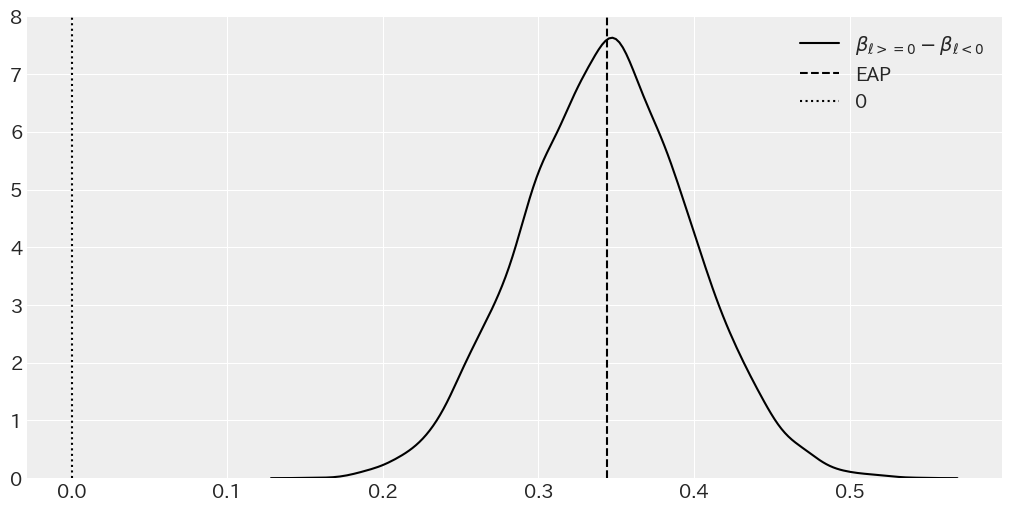

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(post_m_pre, ax=ax, color='black', label='$β_{\ell>=0} - β_{\ell<0}$')
ax.axvline(x=post_m_pre.mean(), color='black', linestyle='--', label='EAP')
ax.axvline(x=0, color='black', linestyle=':', label='0')
ax.set_ylabel('')
ax.legend()

## スムージング

### 移動平均によるスムージング

In [7]:
posterior = trace_homo.posterior
beta_samples = posterior['beta'].stack(dims={'chain', 'draw'})

In [18]:
# 介入経過年数をダミー化
time_since_treatment_dummies = dmatrix('C(time_since_treatment) - 1', df, return_type='dataframe')
time_since_treatment_dummies.drop(columns=['C(time_since_treatment)[1000.0]'], axis=1, inplace=True)
beta_pd = pd.DataFrame(beta_samples.T, columns=time_since_treatment_dummies.columns)

In [68]:
beta_pd_rolling = beta_pd.rolling(window=5, axis=1).mean()

/tmp/ipykernel_73210/181488701.py:1: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  beta_pd_rolling = beta_pd.rolling(window=5, axis=1).mean()


In [69]:
beta_df = pd.DataFrame()
beta_df['mean'] = beta_pd.mean()
beta_df['ma'] = beta_pd_rolling.mean()
beta_df['sd'] = beta_pd_rolling.std()
beta_df['hdi_lw'] = beta_pd_rolling.quantile(0.025)
beta_df['hdi_up'] = beta_pd_rolling.quantile(0.975)

ell_list = df['time_since_treatment'].unique()
ell_list.sort()
ell_list = ell_list[0:-1]
# print(ell_list)
beta_df['ell'] = ell_list


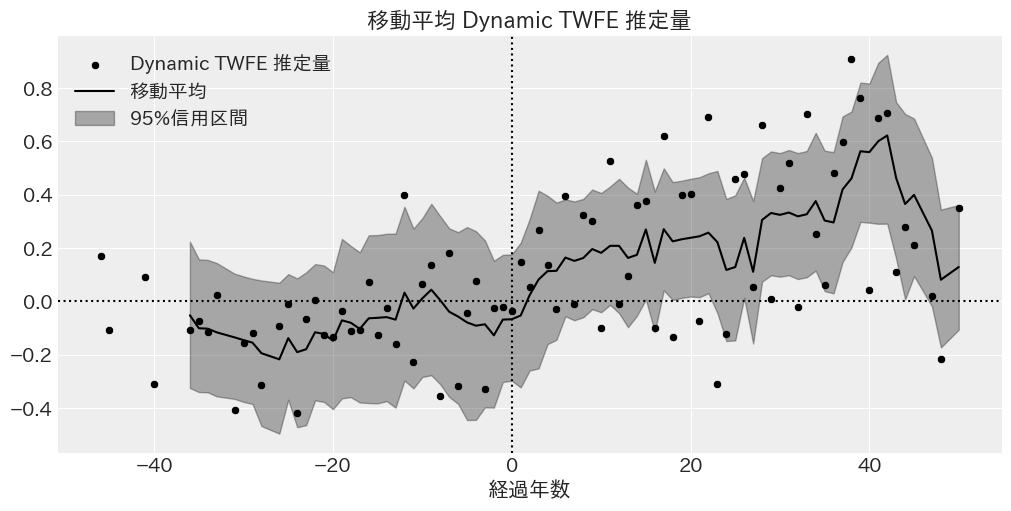

In [80]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='ell', y='mean', data=beta_df, color='k', ax=ax, label='Dynamic TWFE 推定量')
sns.lineplot(x='ell', y='ma', data=beta_df, color='k', ax=ax, label='移動平均')
ax.fill_between(x='ell', y1='hdi_lw', y2='hdi_up', data=beta_df, color='k', alpha=0.3, label='95%信用区間')
ax.axhline(y=0, color='k', linestyle=':')
ax.axvline(x=0, color='k', linestyle=':')
ax.set_title('移動平均 Dynamic TWFE 推定量')
ax.set_xlabel('経過年数')
ax.set_ylabel('')
ax.legend()
plt.savefig('../../docs/figures/dynamic_twfe/MA_ATT.png', bbox_inches='tight')

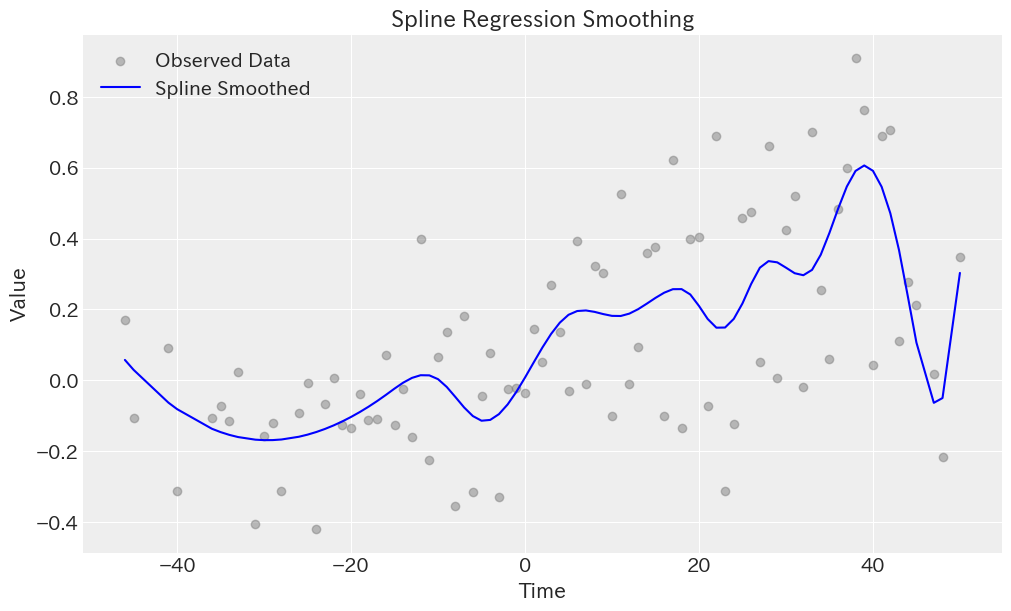

In [ ]:
# スプライン回帰．ブートストラップ法でなければ信頼区間を求めることが出来ない．

from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(beta_df['ell'], beta_df['mean'], s=4)
spline_smoothed = spline(beta_df['ell'])

# プロットの作成
plt.figure(figsize=(10, 6))
plt.scatter(beta_df['ell'], beta_df['mean'], label='Observed Data', color='gray', alpha=0.5)
plt.plot(beta_df['ell'], spline_smoothed, label='Spline Smoothed', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Spline Regression Smoothing')
plt.legend()
plt.show()

### 状態空間モデル

$$
\begin{aligned}
\delta_{l} &= \delta_{l-1} + \zeta_l, \quad &\zeta_l \sim \mathcal{N}(0, \sigma_{\zeta}^2)\\
\mu_{l} &= \mu_{l-1} + \delta_{l-1} + w_l, \quad &w_l \sim \mathcal{N}(0, \sigma_{w}^2)\\
\beta_{l} &= \beta_{l-1} + \mu_{l} + v_l, \quad &v_l \sim \mathcal{N}(0, \sigma_{v}^2)\\
\end{aligned}
$$

In [12]:
beta_df

mean     sd  hdi_lwr  hdi_upr  \
beta[C(time_since_treatment)[-46.0]] -0.316  0.318   -0.896    0.332   
beta[C(time_since_treatment)[-45.0]]  0.182  0.320   -0.479    0.786   
beta[C(time_since_treatment)[-41.0]] -0.355  0.277   -0.901    0.181   
beta[C(time_since_treatment)[-40.0]]  0.137  0.313   -0.466    0.760   
beta[C(time_since_treatment)[-36.0]] -0.226  0.258   -0.743    0.265   
...                                     ...    ...      ...      ...   
beta[C(time_since_treatment)[44.0]]   0.763  0.251    0.264    1.246   
beta[C(time_since_treatment)[45.0]]   0.043  0.262   -0.490    0.552   
beta[C(time_since_treatment)[47.0]]   0.688  0.329    0.066    1.325   
beta[C(time_since_treatment)[48.0]]   0.706  0.366    0.017    1.396   
beta[C(time_since_treatment)[50.0]]   0.278  0.312   -0.294    0.903   

                                      time_since_treatment  
beta[C(time_since_treatment)[-46.0]]                 -46.0  
beta[C(time_since_treatment)[-45.0]]                 -45.0  
beta[C(time_since_treatment)[-41.0]]                 -41.0  
beta[C(time_since_treatment)[-40.0]]                 -40.0  
beta[C(time_since_treatment)[-36.0]]                 -36.0  
...                                                    ...  
beta[C(time_since_treatment)[44.0]]                   44.0  
beta[C(time_since_treatment)[45.0]]                   45.0  
beta[C(time_since_treatment)[47.0]]                   47.0  
beta[C(time_since_treatment)[48.0]]                   48.0  
beta[C(time_since_treatment)[50.0]]                   50.0  

[87 rows x 5 columns]

In [13]:
beta_df.index = pd.RangeIndex(start=0, stop=len(beta_df), step=1)

In [14]:
# level (Smooth Trend)
ll = st.LevelTrendComponent(order=2)
# 観測誤差
er = st.MeasurementError()

mod = ll + er
ss_mod = mod.build()

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (2,), constraints: Positive, dims: ('trend_shock',)
	sigma_MeasurementError -- shape: (), constraints: Positive, dims: None
	P0 -- shape: (2, 2), constraints: Positive semi-definite, dims: ('state', 'state_aux')


In [15]:
ss_mod.coords

{'trend_state': ['level', 'trend'],
 'trend_shock': ['level', 'trend'],
 'state': ['level', 'trend'],
 'state_aux': ['level', 'trend'],
 'observed_state': ['data'],
 'observed_state_aux': ['data'],
 'shock': ['level', 'trend'],
 'shock_aux': ['level', 'trend']}

In [16]:
with pm.Model(coords=ss_mod.coords) as model_smooth:
    # 初期値の分散
    P0_diag = pm.Gamma('P0_diag', alpha=2, beta=1, dims=['state'])
    P0 = pm.Deterministic('P0', pt.diag(P0_diag), dims=['state', 'state_aux'])
    
    # 初期値
    initial_trend = pm.Normal('initial_trend', sigma=1, dims=['trend_state'])
    
    # 状態変数の分散
    sigma_trend = pm.HalfCauchy('sigma_trend', beta=1, dims=['trend_shock'])
    sigma_MeasurementError = pm.HalfCauchy('sigma_MeasurementError', beta=1)
    
    
    ss_mod.build_statespace_graph(data=beta_df['mean'], mode='JAX')

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:92: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


In [17]:
model_smooth

               P0_diag ~ Gamma(2, f())
         initial_trend ~ Normal(0, 1)
           sigma_trend ~ HalfCauchy(0, 1)
sigma_MeasurementError ~ HalfCauchy(0, 1)
                    P0 ~ Deterministic(f(P0_diag))
                   obs ~ KalmanFilter(f(initial_trend, P0_diag, sigma_MeasurementError, sigma_trend), f(initial_trend, P0_diag, sigma_MeasurementError, sigma_trend), f(initial_trend, P0_diag, sigma_MeasurementError, sigma_trend))

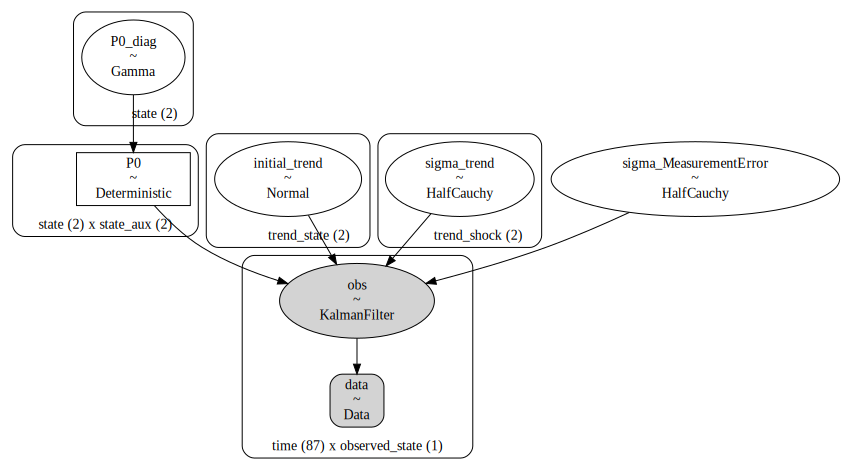

In [18]:
pm.model_to_graphviz(model_smooth)

In [19]:
with model_smooth:
    trace_smoothing = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42,
        target_accept=.998
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [20]:
az.to_netcdf(trace_smoothing, './mcmc_sample/dynamic/smoothing_20250111.nc')

'./mcmc_sample/dynamic/smoothing_20250111.nc'

In [21]:
az.summary(trace_smoothing, hdi_prob=0.95)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
initial_trend[level]   -0.027  0.768    -1.541      1.499      0.010    0.009   
initial_trend[trend]    0.000  0.736    -1.509      1.420      0.009    0.009   
P0_diag[level]          1.725  1.258     0.061      4.195      0.014    0.010   
P0_diag[trend]          1.697  1.277     0.031      4.171      0.014    0.010   
sigma_trend[level]      0.018  0.013     0.000      0.043      0.000    0.000   
sigma_trend[trend]      0.002  0.002     0.000      0.006      0.000    0.000   
sigma_MeasurementError  0.229  0.018     0.196      0.265      0.000    0.000   
P0[level, level]        1.725  1.258     0.061      4.195      0.014    0.010   
P0[level, trend]        0.000  0.000     0.000      0.000      0.000    0.000   
P0[trend, level]        0.000  0.000     0.000      0.000      0.000    0.000   
P0[trend, trend]        1.697  1.277     0.031      4.171      0.014    0.010   

                        ess_bulk  ess_tail  r_hat  
initial_trend[level]      6121.0    4829.0    1.0  
initial_trend[trend]      6531.0    5051.0    1.0  
P0_diag[level]            5969.0    3663.0    1.0  
P0_diag[trend]            5533.0    3720.0    1.0  
sigma_trend[level]        4875.0    2745.0    1.0  
sigma_trend[trend]        4624.0    2088.0    1.0  
sigma_MeasurementError    7969.0    5654.0    1.0  
P0[level, level]          5969.0    3663.0    1.0  
P0[level, trend]          8000.0    8000.0    NaN  
P0[trend, level]          8000.0    8000.0    NaN  
P0[trend, trend]          5533.0    3720.0    1.0

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


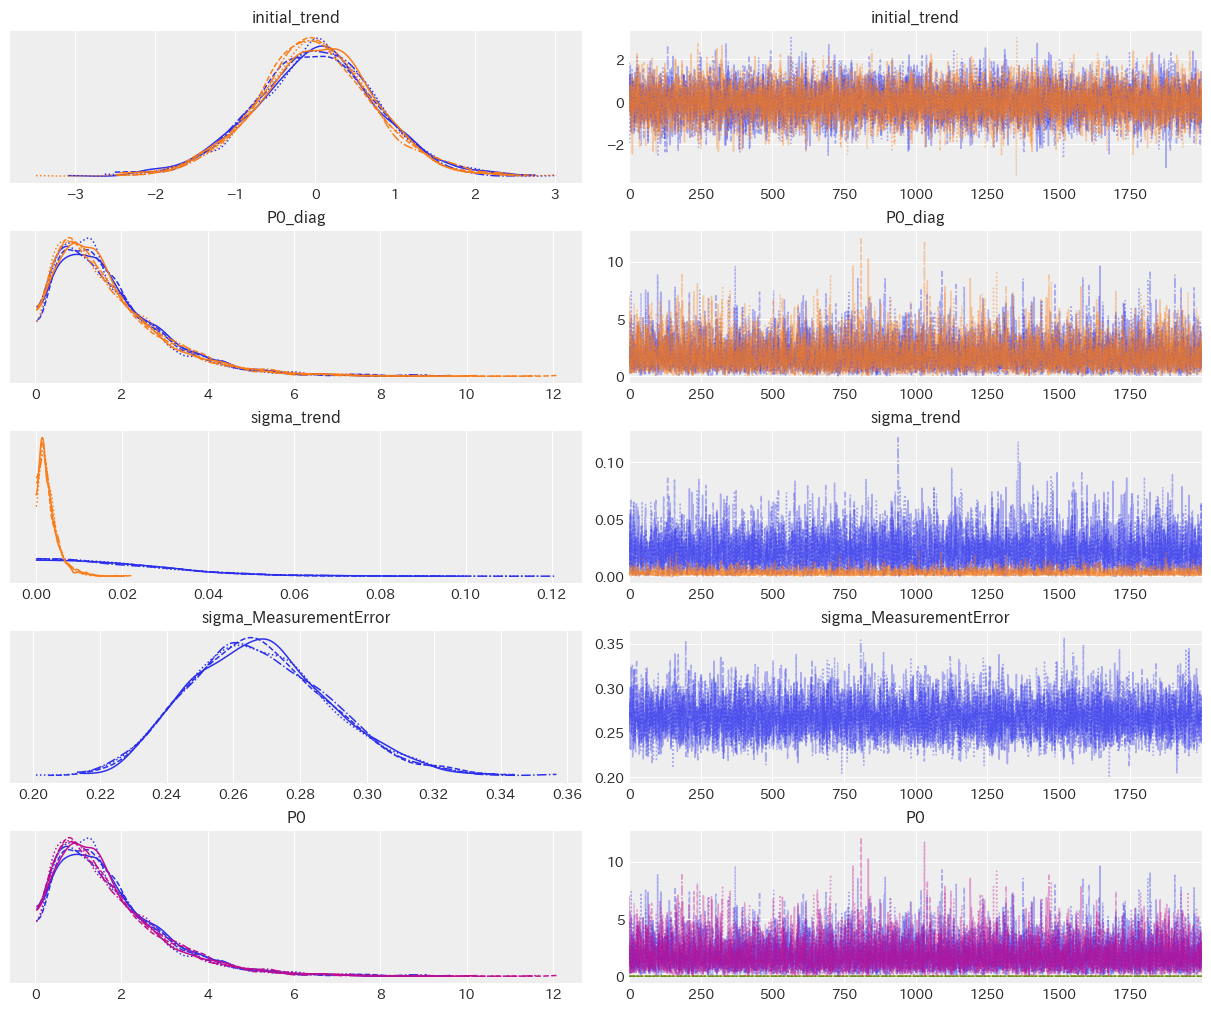

In [16]:
az.plot_trace(trace_smoothing);

In [22]:
post = ss_mod.sample_conditional_posterior(trace_smoothing)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:92: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7FEA1C26CAC0>), RNG(<Generator(PCG64) at 0x7FEA1C26EDC0>), RNG(<Generator(PCG64) at 0x7FEA1C26DFC0>), RNG(<Generator(PCG64) at 0x7FEA1C26E180>), RNG(<Generator(PCG64) at 0x7FEA1BF552A0>), RNG(<Generator(PCG64) at 0x7FE9A87289E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  wa

Output()

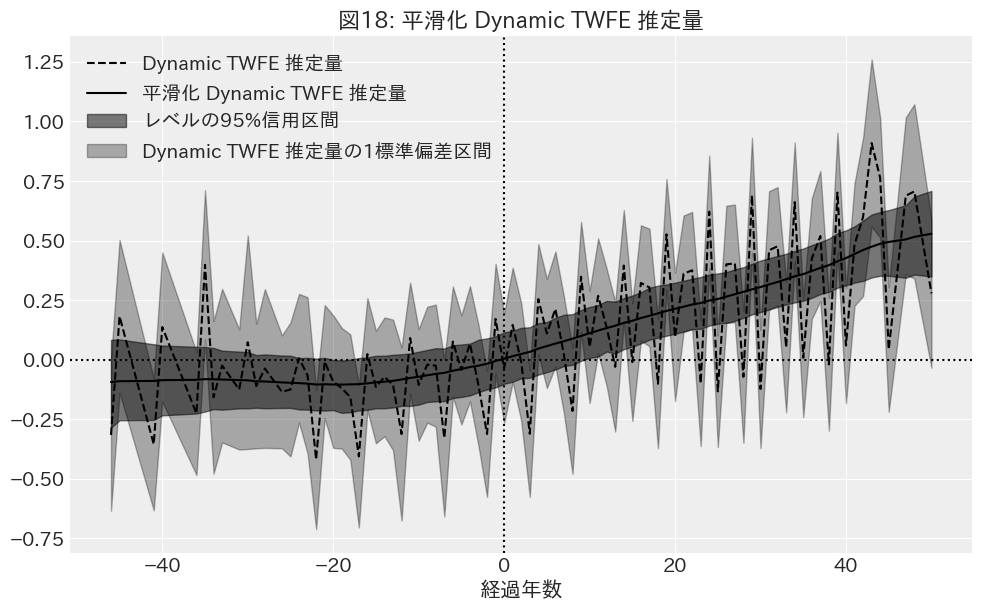

In [24]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))

# 状態
data = post.smoothed_posterior.isel(state=0)
beta_df['smoothed_mean'] = data.mean(dim=['chain', 'draw']).values
hdi = az.hdi(data, hdi_prob=.95).smoothed_posterior
beta_df['state_smoothed_lwr_post'] = hdi[:len(beta_df), 0]
beta_df['state_smoothed_upr_post'] = hdi[:len(beta_df), 1]

# 観測
post_stacked = post.stack(sample=['chain', 'draw'])
hdi_post = az.hdi(post, hdi_prob=0.95).smoothed_posterior_observed.squeeze().values
beta_df['obs_smoothed_lwr_post'] = hdi_post[:, 0]
beta_df['obs_smoothed_upr_post'] = hdi_post[:, 1]

# sns.scatterplot(x='time_since_treatment', y='mean', data=beta_df, ax=ax, color='black', label='事後期待値')
sns.lineplot(x='time_since_treatment', y='mean', data=beta_df, ax=ax, color='black', label='Dynamic TWFE 推定量', ls='--')
ax.plot(
    beta_df['time_since_treatment'],
    beta_df['smoothed_mean'],
    label='平滑化 Dynamic TWFE 推定量',
    color='k',
)
ax.fill_between(
    beta_df['time_since_treatment'],
    y1=beta_df['state_smoothed_lwr_post'],
    y2=beta_df['state_smoothed_upr_post'],
    alpha=0.5, label='レベルの95%信用区間', color='k'
)
ax.fill_between(
    beta_df['time_since_treatment'],
    y1=beta_df['mean'] - beta_df['sd'],
    y2=beta_df['sd'] + beta_df['mean'],
    alpha=0.3, label='Dynamic TWFE 推定量の1標準偏差区間', color='k'
)
ax.axvline(x=0, color='k', linestyle=':')
ax.axhline(y=0, color='k', linestyle=':')
ax.set_title('図18: 平滑化 Dynamic TWFE 推定量')
ax.set_xlabel('経過年数')
ax.set_ylabel('')
ax.legend()
# path = '../../docs/figures/dynamic_twfe/smoothed_ATT.png'
# plt.savefig(path)

In [26]:
beta_df.rename(columns={'time_since_treatment': 'ell'}, inplace=True)
path = '../../data/processed/dynamic_twfe/beta_smoothed.csv'
beta_df.to_csv(path)

## 解釈

In [37]:
percent_of_1 =time_since_treatment_dummies.mean().mean()
print(f'ダミー変数の1の割合: {percent_of_1:.3%}')

ダミー変数の1の割合: 0.495%
